# Consumer Complaint Retrieval Augmented Generation (RAG) - Exploratory Data Analysis

This notebook provides a comprehensive exploratory data analysis (EDA) of the CFPB Consumer Complaint dataset. The goal is to understand the structure, distribution, and content of the complaints to better inform our RAG pipeline strategy.

### Key objectives:
1. **Initial distribution analysis**: Understanding the raw volume and product categories.
2. **Narrative analysis**: Deep dive into the text data (length, keywords).
3. **Cleaning and Filter validation**: Verifying the impact of our preprocessing steps.
4. **Stratified Sampling**: Ensuring a representative dataset for downstream tasks.

In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# allow imports from project root
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# local helpers
from src.file_handling import load_raw_data, save_processed_data
import src.eda as eda_mod
from src.preprocess import preprocess_data, create_stratified_sample
from src import config

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 200)

print("✓ Imports complete!")
print(f"Project root: {project_root}")

✓ Imports complete!
Project root: c:\Users\Acer\Documents\KAIM_PROJECT\TEST\rag-complaint-chatbot


## 1. Load Raw Data

We load the official CFPB complaints dataset. Note that this is a large CSV file with millions of records.

In [2]:

raw_data_path = project_root / "data" / "raw" / "complaints.csv"

if not raw_data_path.exists():
    print(f"❌ File not found at: {raw_data_path}. Please download the dataset.")
else:
    df_raw = load_raw_data(raw_data_path)
    print(f"✓ Loaded {len(df_raw):,} complaints")

[OK] Loaded 9,609,797 DATA from complaints.csv
✓ Loaded 9,609,797 complaints


## 2. Global Distribution Analysis

First, we look at the relative volume of complaints across all product categories to identify the major areas of consumer concern.

c:\Users\Acer\Documents\KAIM_PROJECT\TEST\rag-complaint-chatbot\src\eda.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.values, y=counts.index, palette="viridis")


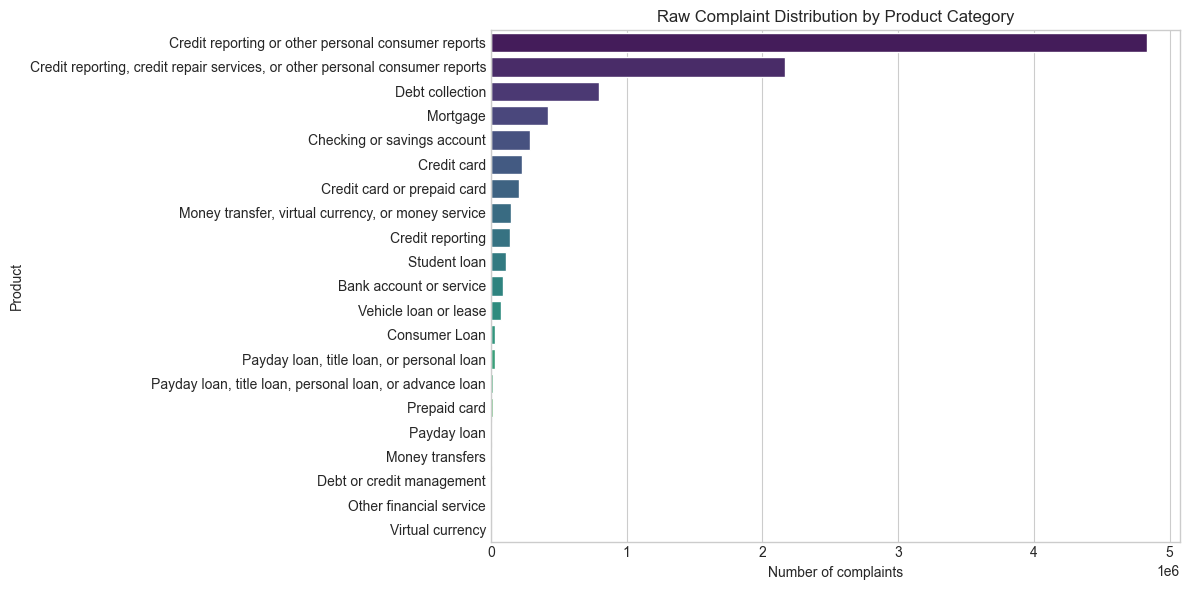

In [3]:
eda_mod.plot_product_distribution(df_raw, title="Raw Complaint Distribution by Product Category")

## 2.1 Initial Narrative Length Analysis

**Objective**: Calculate and visualize the length (word count) of the Consumer complaint narrative on the raw data.

**Key Question**: Are there very short or very long narratives? Identifying these outliers early helps inform our filtering strategy.

Narrative Length Stats:
count    9.609797e+06
mean     5.515649e+01
std      1.495169e+02
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      5.000000e+01
max      6.469000e+03
Name: Consumer complaint narrative, dtype: float64

Very short narratives (< 5 words): 6632216
Very long narratives (> 500 words): 160989


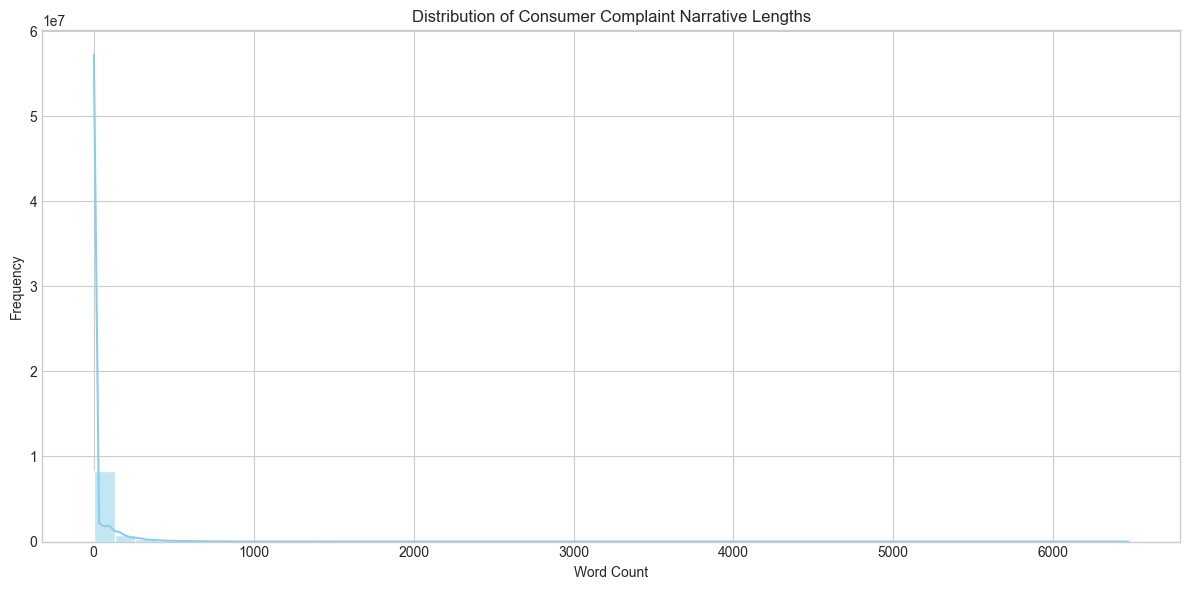

In [4]:
# Analyze length on raw data
# Note: Some raw records may have empty narratives, which we handle (fillna)
eda_mod.plot_narrative_length_distribution(df_raw, narrative_col='Consumer complaint narrative')

## 2.2 Narrative Presence Analysis

A significant number of complaints do not include a public narrative. Since our RAG pipeline relies on text semantic search, we must filter for those that have valid text content.

In [5]:
presence = eda_mod.narrative_presence_analysis(df_raw)
print(f"Total records: {presence['total']:,}")
print(f"Records with narration: {presence['with_narrative']:,} ({presence['percentage_with']:.2f}%)")
print(f"Records without narration: {presence['without_narrative']:,}")

Total records: 9,609,797
Records with narration: 2,980,756 (31.02%)
Records without narration: 6,629,041


## 3. Preprocessing & Filtering

We apply the standard preprocessing pipeline which:
1. **Filters** for target products relevant to our business domain.
2. **Cleans** the text narratives (removes XXXXX masking where possible, normalizes whitespace).
3. **Standardizes** product labels for consistency.
4. **Saves** the result for downstream use.

In [6]:
df_filtered = preprocess_data(df_raw)
print(f"\nFiltered dataset shape: {df_filtered.shape}")

# Explicitly save the cleaned and filtered dataset
save_path = project_root / "data" / "filtered_complaints.csv"
save_processed_data(df_filtered, save_path)

Starting professional preprocessing pipeline...
[OK] Filtered products: kept 1,243,100 rows from the target labels.
[OK] Standardized products into categories: ['Credit card', 'Personal loan', 'Savings account', 'Money transfers', 'Buy Now, Pay Later (BNPL)']
[OK] Dropped 661,942 rows with empty narratives; 581,158 remain
[OK] Dropped PII columns: ['ZIP code', 'Tags', 'Consumer consent provided?', 'Company public response']
[OK] Cleaned narratives

Filtered dataset shape: (581158, 16)
[OK] Saved 581,158 DATA to filtered_complaints.csv


WindowsPath('c:/Users/Acer/Documents/KAIM_PROJECT/TEST/rag-complaint-chatbot/data/filtered_complaints.csv')

### Visualizing the Filtered Dataset

This visualization shows the distribution of standardized products in our refined dataset.

c:\Users\Acer\Documents\KAIM_PROJECT\TEST\rag-complaint-chatbot\src\eda.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.values, y=counts.index, palette="viridis")


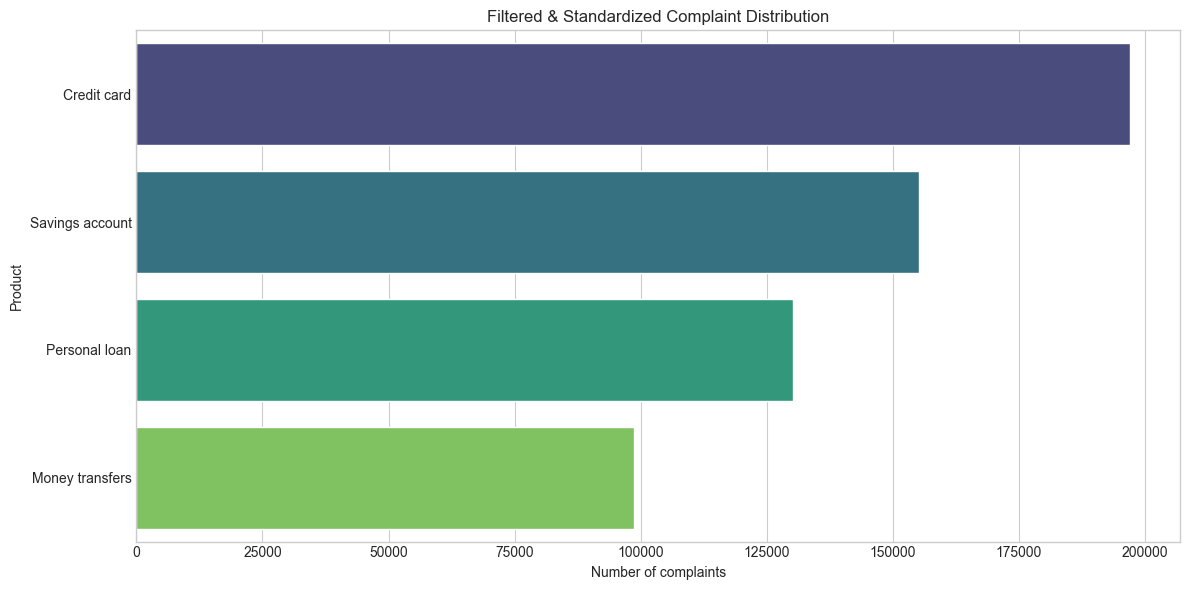

In [7]:
eda_mod.plot_product_distribution(df_filtered, title="Filtered & Standardized Complaint Distribution")

## 4. Deep Dive: Narrative Text Analysis

Now we analyze the textual content of the narratives to gain insights for chunking and search strategies. We explicitly look at the distribution of word counts to identify outliers (very short or very long narratives).

Narrative Length Stats:
count    581158.00000
mean        201.95107
std         218.72521
min           0.00000
25%          81.00000
50%         138.00000
75%         252.00000
max        6266.00000
Name: clean_narrative, dtype: float64

Very short narratives (< 5 words): 345
Very long narratives (> 500 words): 39906


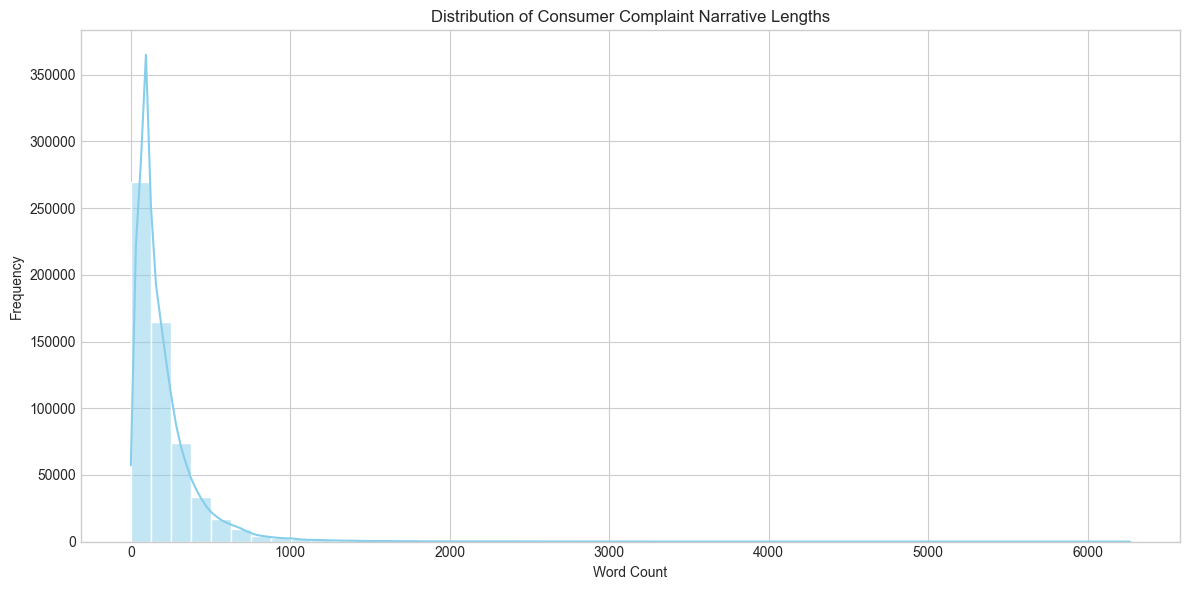

In [8]:
eda_mod.plot_narrative_length_distribution(df_filtered)

### Narrative Length by Product

Analyzing narrative length across different product categories to identify variability in consumer description detail.

c:\Users\Acer\Documents\KAIM_PROJECT\TEST\rag-complaint-chatbot\src\eda.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='length', y=product_col, data=df_plot, palette="muted")


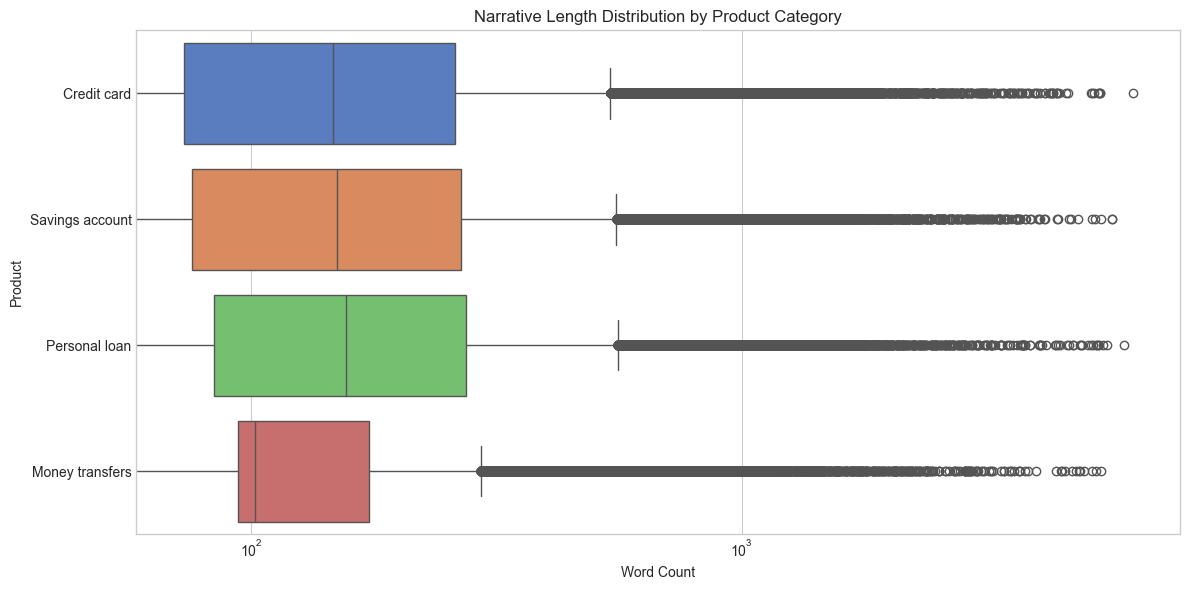

In [9]:
eda_mod.plot_length_by_product(df_filtered)

### Top Keywords Identification

 Identifying high-frequency terms helps us understand common pain points and consumer language.

c:\Users\Acer\Documents\KAIM_PROJECT\TEST\rag-complaint-chatbot\src\eda.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="rocket")


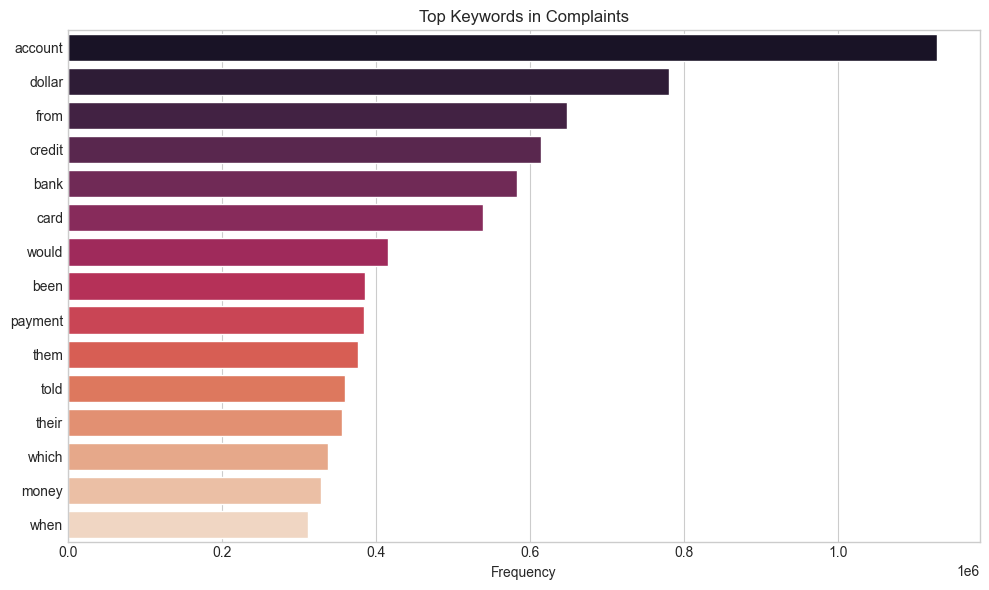

In [10]:
eda_mod.plot_top_keywords(df_filtered)

## 5. Temporal and Company Analysis

Understanding the volume over time and the most complained-about companies.

c:\Users\Acer\Documents\KAIM_PROJECT\TEST\rag-complaint-chatbot\src\eda.py:116: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  daily_counts = df_temp.resample('M', on='Date received').size()


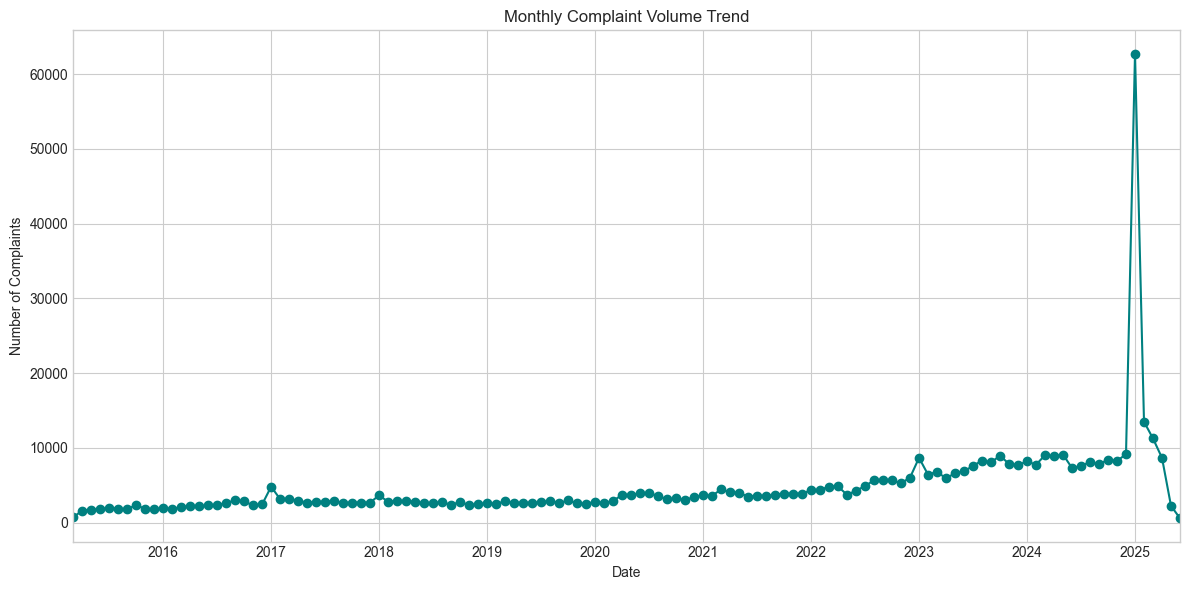

c:\Users\Acer\Documents\KAIM_PROJECT\TEST\rag-complaint-chatbot\src\eda.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.values, y=counts.index, palette="magma")


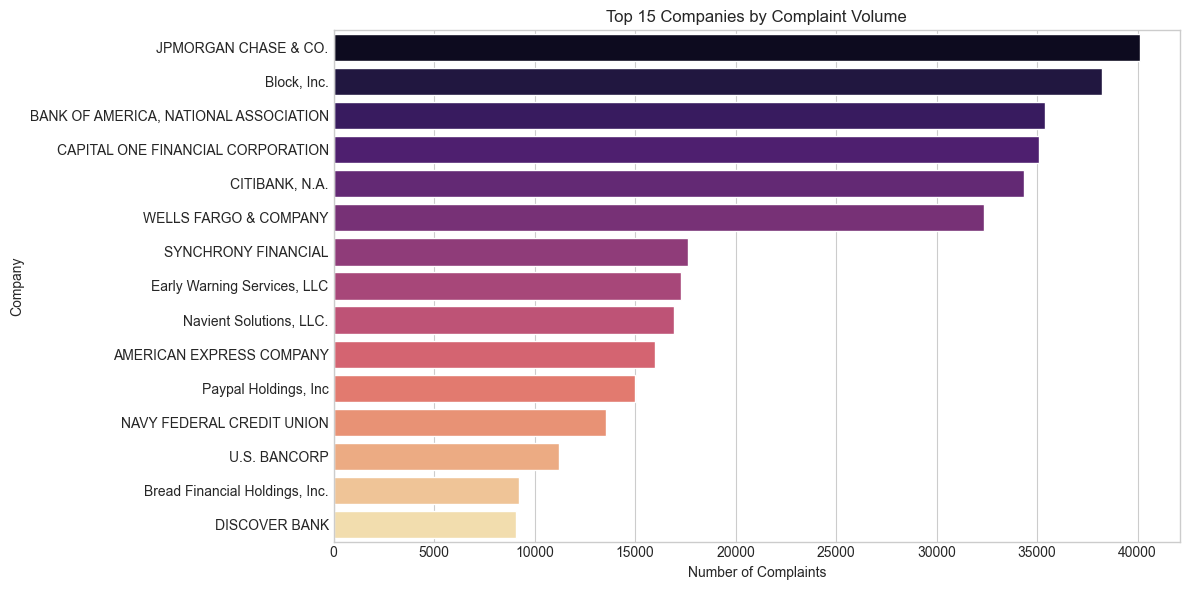

In [11]:
eda_mod.plot_temporal_trends(df_filtered)
plt.show()
eda_mod.plot_company_distribution(df_filtered)

## 6. Stratified Sampling for RAG Prototyping

To build a responsive prototype, we create a representative sample that maintains product distribution proportions.

c:\Users\Acer\Documents\KAIM_PROJECT\TEST\rag-complaint-chatbot\src\eda.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="rocket")


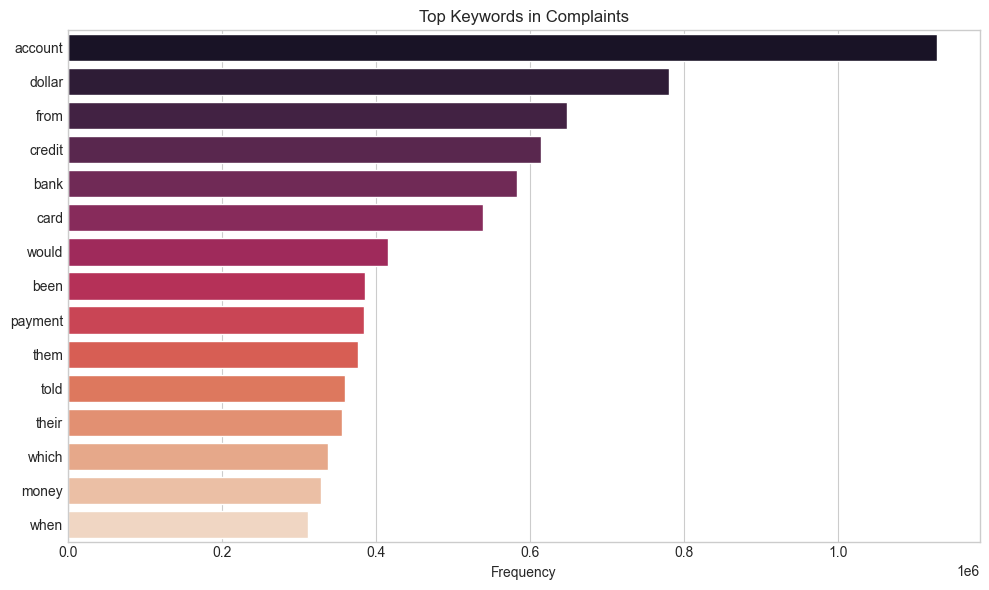

In [12]:
eda_mod.plot_top_keywords(df_filtered)


## 5. Temporal and Company Analysis

Understanding the volume over time and the most complained-about companies.

c:\Users\Acer\Documents\KAIM_PROJECT\TEST\rag-complaint-chatbot\src\eda.py:116: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  daily_counts = df_temp.resample('M', on='Date received').size()


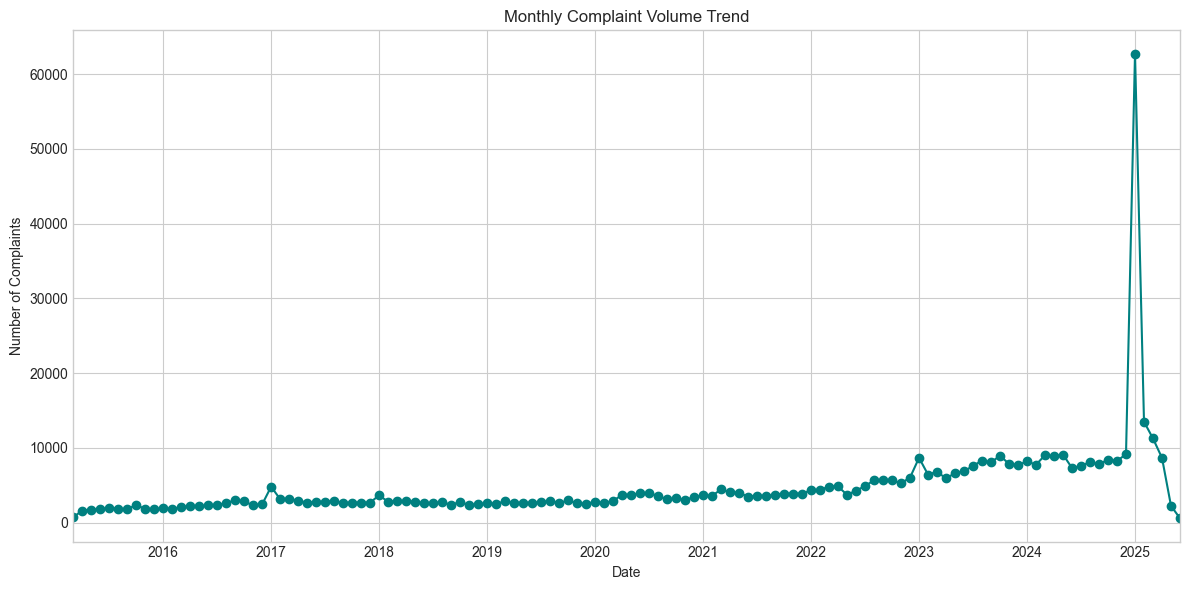

c:\Users\Acer\Documents\KAIM_PROJECT\TEST\rag-complaint-chatbot\src\eda.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.values, y=counts.index, palette="magma")


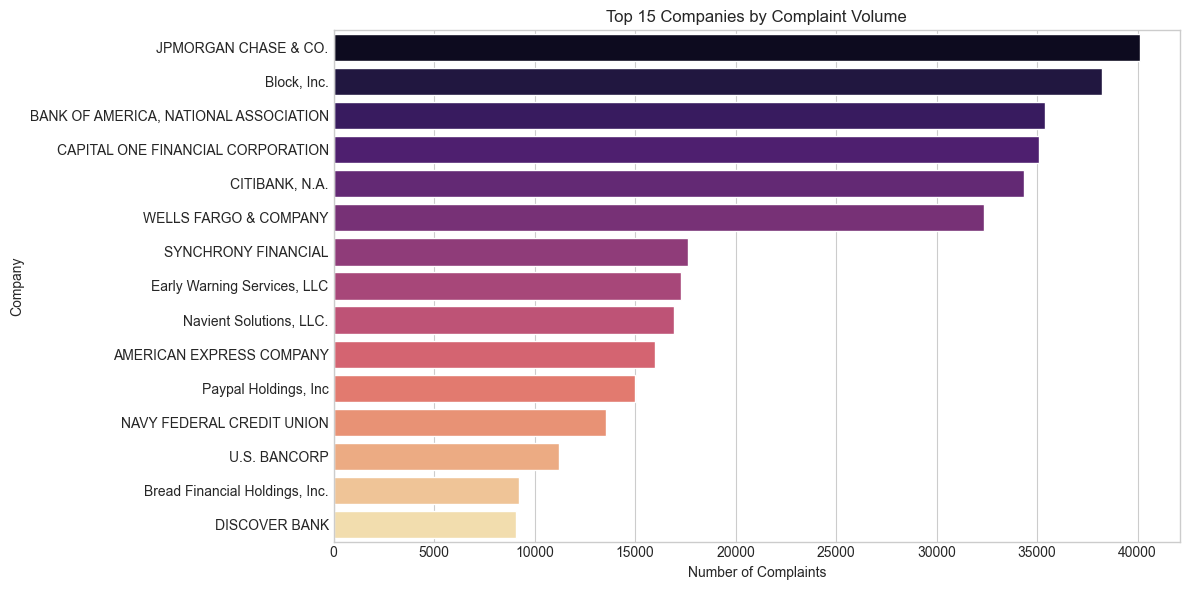

In [11]:
eda_mod.plot_temporal_trends(df_filtered)
plt.show()
eda_mod.plot_company_distribution(df_filtered)

## 6. Stratified Sampling for RAG Prototyping

To build a responsive prototype, we create a representative sample that maintains product distribution proportions.

In [12]:
target_size = 15000
df_sampled = create_stratified_sample(df_filtered, target_size=target_size)

# Final verification of counts
print(f"Final Sample Size: {len(df_sampled):,}")
print("Sample distribution:")
print(df_sampled['Product'].value_counts(normalize=True))

[OK] Created stratified sample: 15,000 rows

Proportional Representation Check (Product %):
                 Original %  Sample %
Product                              
Credit card           33.92     33.92
Money transfers       16.98     16.98
Personal loan         22.39     22.39
Savings account       26.71     26.71
Final Sample Size: 15,000
Sample distribution:
Product
Credit card        0.339200
Savings account    0.267067
Personal loan      0.223933
Money transfers    0.169800
Name: proportion, dtype: float64
